# Coarse-grained Preprocessing


## Preprocessing


In [3]:
from pandas import read_excel
import pandas as pd
import numpy as np
from datetime import datetime
import os
os.environ["KERAS_BACKEND"] = "tensorflow" 
import keras
def parse(x):
    return datetime.strptime(x,'%Y%m%d')
def get_dataframe(data_type,date_no):
    path=f'{data_type}/{date_no}'
    data=pd.read_excel(path)
    data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
    pd.set_option('future.no_silent_downcasting', True)
    data.replace('/', np.nan, inplace=True)
    data.set_index('Date', inplace=True)
    os.makedirs(f'data/new_data/{data_type}', exist_ok=True)
    data.describe().to_csv(f'data/new_data/{data_type}/{date_no}_statistic.csv',encoding='utf-8-sig')
    print(data.index)
    output_dir = f'data_set/{data_type}'
    os.makedirs(output_dir, exist_ok=True)
    data.to_csv(f'data_set/{data_type}/processed_{date_no}.csv')
    return data

## Fine-grained preprocessing
1. Use a coarse hashmap derived from the manual recorded csv file to calculate the total calories for a meal.
2. Extract number from ```Insulin dose - s.c.```,```Insulin dose - i.v.```,```Non-insulin hypoglycemic agents```
3. Padding the empty cell in ```CSII - basal insulin (Novolin R, IU / H)``` columns with the very above non-empty cell.
4. The ```CGM``` is the variables we want to predict,so remove other irrelavant columns(10, 11, 12, 13, 14, 15,16,17)
5. If the data is unavailable ,fill in it with the nearly average value of calories in a meal.
### NOTE:
1. The scaler's dimentionality must match the prediction.

In [42]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,MultiLabelBinarizer
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import re
import warnings
import csv
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
#转成有监督数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    #数据序列(也将就是input) input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
        #预测数据（input对应的输出值） forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    #拼接 put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # 删除值为NAN的行 drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
hash_table = {}
with open('ref_calories.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # 使用第一列作为键，第二列作为值，填充哈希表
        if len(row) >= 2:  # 确保行中至少有两列
            key = row[0]
            value = row[1]
            hash_table[key] = value
def extract_dietary_words(text):
    if pd.notna(text):
        res=0.0
        phrases = re.findall(r'\b[A-Za-z\s]+(?=\s\d+ g|\b)', text)
        phrases = [phrase.strip(' g\n') for phrase in phrases]
        numbers = re.findall(r'\b\d+\b', text)
        for i, phrase in enumerate(phrases):
            if phrase=='':
                break
            if i>=len(numbers):
                break
            res +=int(numbers[i]) * float(hash_table.get(phrase,2))#phrases_stripped
        return res#', '.join(phrases_stripped[:-1]) + phrases_stripped[-1]
    else:
        return np.nan
def binarysum(x):
    # 这里是二进制转十进制的逻辑，你可以根据需要进行修改
    res=int(''.join(map(str, x)), 2)
    return res

def fine_preprocess(data_type,date_no):
    # 数据预处理：加载数据集
    path = f'data_set/{data_type}/processed_{date_no}.csv'
    dataset = read_csv(path, header=0, index_col=0)
    # 将 'data not available' 替换为 NaN
    dataset.loc[dataset['Dietary intake'] == 'data not available', 'Dietary intake'] = '258.44'
    dataset.loc[dataset['CSII - basal insulin (Novolin R, IU / H)']=='temporarily suspend insulin delivery','CSII - basal insulin (Novolin R, IU / H)']=0.0
    dataset.loc[dataset['CSII - bolus insulin (Novolin R, IU)']=='temporarily suspend insulin delivery','CSII - bolus insulin (Novolin R, IU)']=0.0
    
    values = dataset.values
    s_c_col = dataset.iloc[:, 5].astype(str)
    n_ha_col = dataset.iloc[:, 6].astype(str)
    i_v_col = dataset.iloc[:, 9].astype(str)

    # Extract the IU values using regular expressions
    #Non-insulin hypoglycemic agents
    s_c_iu = s_c_col.str.extract(r'(\d+)\s*IU', expand=False)
    i_v_iu = i_v_col.str.extract(r'(\d+)\s*IU', expand=False)
    n_ha_iu = n_ha_col.str.extract(r'\b(\d+)\b', expand=False)
    # Convert extracted values to numeric
    s_c_iu = pd.to_numeric(s_c_iu, errors='coerce')
    i_v_iu = pd.to_numeric(i_v_iu, errors='coerce')
    n_ha_iu = pd.to_numeric(n_ha_iu, errors='coerce')
    # Add the extracted values back to the DataFrame
    dataset['IU- s.c.'] = s_c_iu
    dataset['IU- i.v.'] = i_v_iu
    dataset['Non-insulin hypoglycemic agents - mg']=n_ha_iu
    dataset.drop('Insulin dose - s.c.',axis=1,inplace=True)
    dataset.drop('Insulin dose - i.v.',axis=1,inplace=True)
    dataset.drop('Non-insulin hypoglycemic agents',axis=1,inplace=True)
    dataset.drop('饮食',axis=1,inplace=True)
    dataset['Dietary calories'] = dataset['Dietary intake'].apply(extract_dietary_words)
    #print(dataset.describe())
    dataset.drop('Dietary intake',axis=1,inplace=True)
    # Assuming dataset is your DataFrame
    dataset['CSII - basal insulin (Novolin R, IU / H)'] = dataset['CSII - basal insulin (Novolin R, IU / H)'].ffill(limit=12).astype(float)
    dataset.fillna(0, inplace=True)
    values = dataset.values
    #保证为float ensure all data is float
    values = values.astype('float32')
    #归一化 normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    #print(scaled)
    reframed = series_to_supervised(scaled, 1, 1)
    reframed.drop(reframed.columns[[10, 11, 12, 13, 14, 15,16,17]], axis=1, inplace=True)
    #print(reframed)
    return reframed,scaler

The best split train-test retio is 4:1,I guess. 

In [5]:
def split_data(reframed):
    #数据准备
    #把数据分为训练数据和测试数据 split into train and test sets
    values = reframed.values
    #拿一年的时间长度训练
    #print(reframed.shape[0])
    n_train_quarters = int(reframed.shape[0]*0.8)
    #划分训练数据和测试数据
    train = values[:n_train_quarters, :]
    test = values[n_train_quarters:, :]
    #拆分输入输出 split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    #reshape输入为LSTM的输入格式 reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #print ('train_x.shape, train_y.shape, test_x.shape, test_y.shape')
    #print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X,train_y,test_X,test_y

# Model

This is because tensorflow can't be directly imported in python.And keras's BACKEND env should be assigned as one of the following :```tensorflow```,```fax```.

In [6]:
!pip install tensorflow

## Training
### NOTE:
1. the batch size must be a power of 2.

Best hyperparameter ever:
- optimizer:adam,(nadam isn't that bad,but others suffer)
- epochs:20
- batch_size:16
- layers of LSTM:100
- layers of Dense must be 1

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import LSTM
from matplotlib import pyplot
##模型定义 design network
def train(data_type,date_no,train_X,train_y,test_X,test_y):
    model = Sequential()
    model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(100))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    #模型训练 fit network
    history = model.fit(train_X, train_y, epochs=20, batch_size=16, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
    #输出 plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.savefig(f'data_set/trained_{data_type}_{date_no}.png')
    pyplot.show()
    pyplot.close()
    return model

## Prediction

In [8]:
from numpy import concatenate
def predict(model,scalar,train_X,train_y,test_X,test_y):
    #进行预测 make a prediction
    print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    #预测数据逆缩放 invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    #print('inv_yhat')
    #print(inv_yhat.shape)
    #print(scaler.n_features_in_)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, 0]
    inv_yhat = np.array(inv_yhat)
    #真实数据逆缩放 invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]

    #画出真实数据和预测数据
    pyplot.plot(inv_yhat,label='prediction')
    pyplot.plot(inv_y,label='true')
    pyplot.legend()
    pyplot.savefig(f'predict_samples')
    pyplot.show()
    pyplot.close()
    return inv_y, inv_yhat

# Calculate RMSE

In [9]:
from math import sqrt
# calculate RMSE
def cal_rmse(inv_y, inv_yhat):
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)

## Enumerate all files

DatetimeIndex(['2021-07-30 16:43:00', '2021-07-30 16:58:00',
               '2021-07-30 17:13:00', '2021-07-30 17:28:00',
               '2021-07-30 17:43:00', '2021-07-30 17:58:00',
               '2021-07-30 18:13:00', '2021-07-30 18:28:00',
               '2021-07-30 18:43:00', '2021-07-30 18:58:00',
               ...
               '2021-08-06 10:43:00', '2021-08-06 10:58:00',
               '2021-08-06 11:13:00', '2021-08-06 11:28:00',
               '2021-08-06 11:43:00', '2021-08-06 11:58:00',
               '2021-08-06 12:13:00', '2021-08-06 12:28:00',
               '2021-08-06 12:43:00', '2021-08-06 12:58:00'],
              dtype='datetime64[ns]', name='Date', length=658, freq=None)
657
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(525, 1, 9) (525,) (132, 1, 9) (132,)
Epoch 1/20
33/33 - 2s - 53ms/step - loss: 0.4105 - val_loss: 0.1690
Epoch 2/20
33/33 - 0s - 2ms/step - loss: 0.1726 - val_loss: 0.1386
Epoch 3/20
33/33 - 0s - 2ms/step - loss: 0.1154 - val_loss: 0.

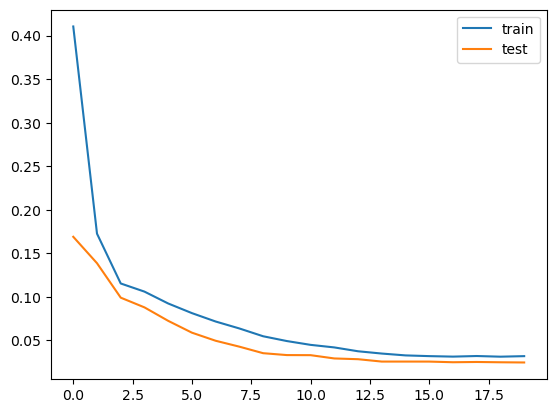

(525, 1, 9) (525,) (132, 1, 9) (132,)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
inv_yhat
(132, 9)


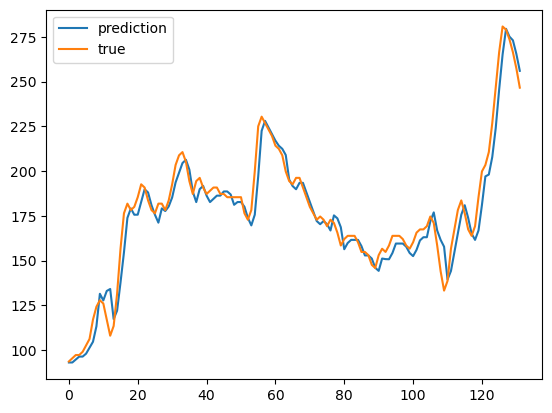

Test RMSE: 8.823
DatetimeIndex(['2021-05-04 10:33:00', '2021-05-04 10:48:00',
               '2021-05-04 11:03:00', '2021-05-04 11:18:00',
               '2021-05-04 11:33:00', '2021-05-04 11:48:00',
               '2021-05-04 12:03:00', '2021-05-04 12:18:00',
               '2021-05-04 12:33:00', '2021-05-04 12:48:00',
               ...
               '2021-05-14 05:03:00', '2021-05-14 05:18:00',
               '2021-05-14 05:33:00', '2021-05-14 05:48:00',
               '2021-05-14 06:03:00', '2021-05-14 06:18:00',
               '2021-05-14 06:33:00', '2021-05-14 06:48:00',
               '2021-05-14 07:03:00', '2021-05-14 07:18:00'],
              dtype='datetime64[ns]', name='Date', length=948, freq=None)
947
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(757, 1, 9) (757,) (190, 1, 9) (190,)
Epoch 1/20
48/48 - 2s - 38ms/step - loss: 0.1657 - val_loss: 0.0948
Epoch 2/20
48/48 - 0s - 2ms/step - loss: 0.1174 - val_loss: 0.0749
Epoch 3/20
48/48 - 0s - 2ms/step - loss: 0.10

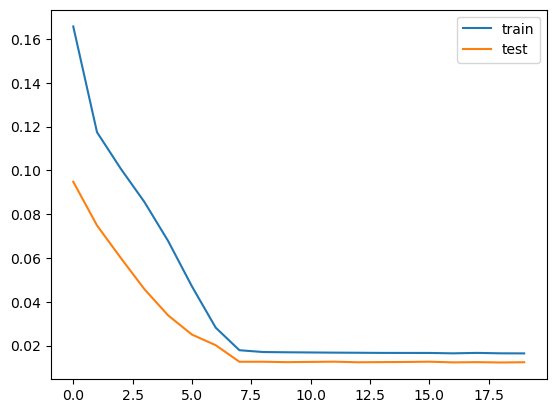

(757, 1, 9) (757,) (190, 1, 9) (190,)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
inv_yhat
(190, 9)


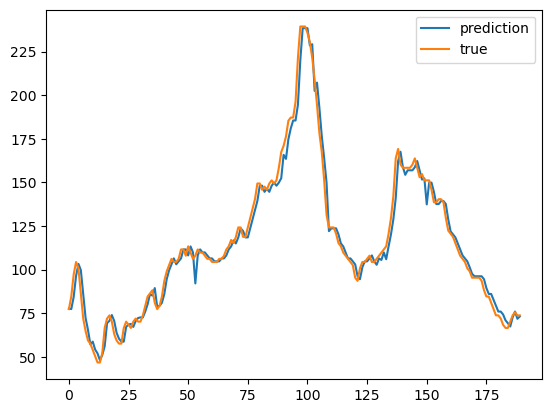

Test RMSE: 6.113
DatetimeIndex(['2021-05-21 13:32:00', '2021-05-21 13:47:00',
               '2021-05-21 14:02:00', '2021-05-21 14:17:00',
               '2021-05-21 14:32:00', '2021-05-21 14:47:00',
               '2021-05-21 15:02:00', '2021-05-21 15:17:00',
               '2021-05-21 15:32:00', '2021-05-21 15:47:00',
               ...
               '2021-05-31 04:32:00', '2021-05-31 04:47:00',
               '2021-05-31 05:02:00', '2021-05-31 05:17:00',
               '2021-05-31 05:32:00', '2021-05-31 05:47:00',
               '2021-05-31 06:02:00', '2021-05-31 06:17:00',
               '2021-05-31 06:32:00', '2021-05-31 06:47:00'],
              dtype='datetime64[ns]', name='Date', length=933, freq=None)
932
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(745, 1, 9) (745,) (187, 1, 9) (187,)
Epoch 1/20
47/47 - 2s - 44ms/step - loss: 0.1706 - val_loss: 0.0823
Epoch 2/20
47/47 - 0s - 2ms/step - loss: 0.1237 - val_loss: 0.0862
Epoch 3/20
47/47 - 0s - 2ms/step - loss: 0.10

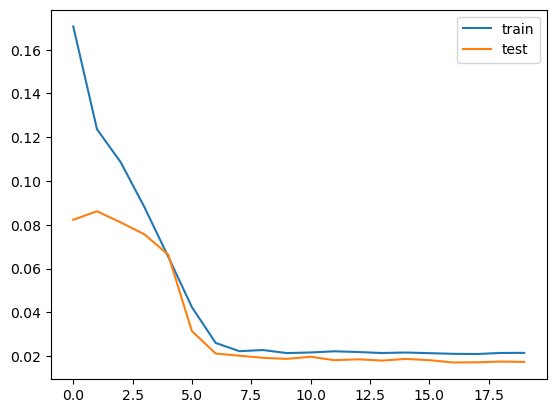

(745, 1, 9) (745,) (187, 1, 9) (187,)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
inv_yhat
(187, 9)


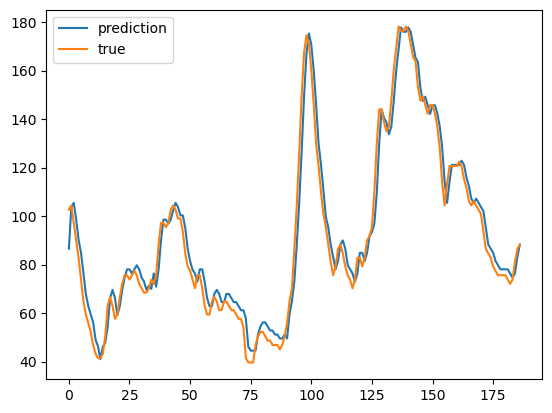

Test RMSE: 6.833
DatetimeIndex(['2021-09-09 16:06:00', '2021-09-09 16:21:00',
               '2021-09-09 16:36:00', '2021-09-09 16:51:00',
               '2021-09-09 17:06:00', '2021-09-09 17:21:00',
               '2021-09-09 17:36:00', '2021-09-09 17:51:00',
               '2021-09-09 18:06:00', '2021-09-09 18:21:00',
               ...
               '2021-09-13 06:51:00', '2021-09-13 07:06:00',
               '2021-09-13 07:21:00', '2021-09-13 07:36:00',
               '2021-09-13 07:51:00', '2021-09-13 08:06:00',
               '2021-09-13 08:21:00', '2021-09-13 08:36:00',
               '2021-09-13 08:51:00', '2021-09-13 09:06:00'],
              dtype='datetime64[ns]', name='Date', length=357, freq=None)
356
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(284, 1, 9) (284,) (72, 1, 9) (72,)
Epoch 1/20
18/18 - 2s - 97ms/step - loss: 0.3451 - val_loss: 0.3787
Epoch 2/20
18/18 - 0s - 3ms/step - loss: 0.2202 - val_loss: 0.2412
Epoch 3/20
18/18 - 0s - 3ms/step - loss: 0.1446

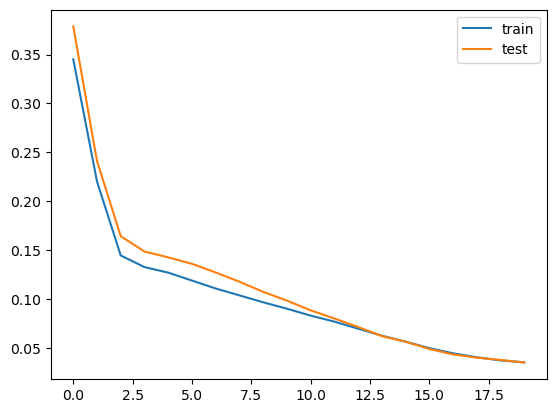

(284, 1, 9) (284,) (72, 1, 9) (72,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
inv_yhat
(72, 9)


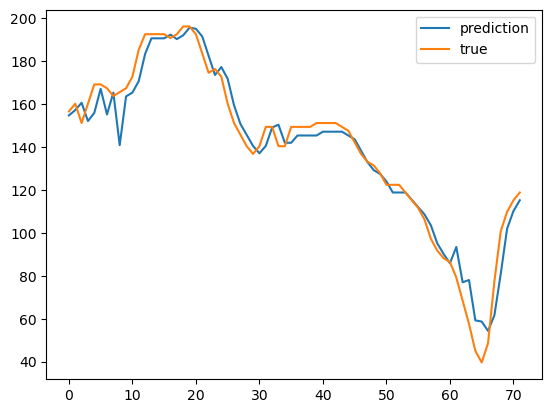

Test RMSE: 7.879
DatetimeIndex(['2021-08-31 17:43:00', '2021-08-31 17:58:00',
               '2021-08-31 18:13:00', '2021-08-31 18:28:00',
               '2021-08-31 18:43:00', '2021-08-31 18:58:00',
               '2021-08-31 19:13:00', '2021-08-31 19:28:00',
               '2021-08-31 19:43:00', '2021-08-31 19:58:00',
               ...
               '2021-09-14 13:58:00', '2021-09-14 14:13:00',
               '2021-09-14 14:28:00', '2021-09-14 14:43:00',
               '2021-09-14 14:58:00', '2021-09-14 15:13:00',
               '2021-09-14 15:28:00', '2021-09-14 15:43:00',
               '2021-09-14 15:58:00', '2021-09-14 16:13:00'],
              dtype='datetime64[ns]', name='Date', length=1339, freq=None)
1338
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(1070, 1, 9) (1070,) (268, 1, 9) (268,)
Epoch 1/20
67/67 - 2s - 31ms/step - loss: 0.1806 - val_loss: 0.0559
Epoch 2/20
67/67 - 0s - 2ms/step - loss: 0.1155 - val_loss: 0.0484
Epoch 3/20
67/67 - 0s - 2ms/step - loss: 

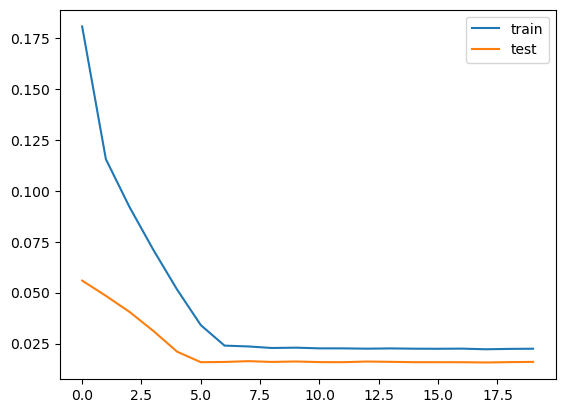

(1070, 1, 9) (1070,) (268, 1, 9) (268,)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
inv_yhat
(268, 9)


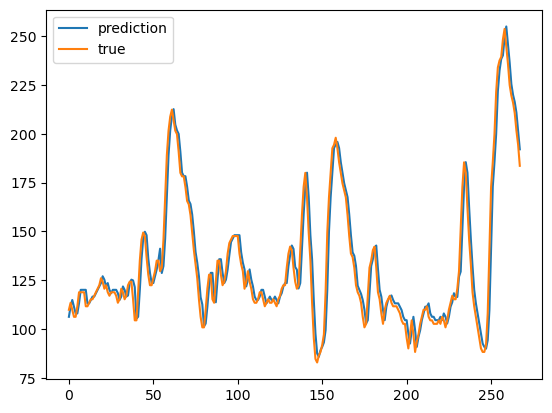

Test RMSE: 8.351
DatetimeIndex(['2021-04-25 17:26:00', '2021-04-25 17:41:00',
               '2021-04-25 17:56:00', '2021-04-25 18:11:00',
               '2021-04-25 18:26:00', '2021-04-25 18:41:00',
               '2021-04-25 18:56:00', '2021-04-25 19:11:00',
               '2021-04-25 19:26:00', '2021-04-25 19:41:00',
               ...
               '2021-05-05 04:11:00', '2021-05-05 04:26:00',
               '2021-05-05 04:41:00', '2021-05-05 04:56:00',
               '2021-05-05 05:11:00', '2021-05-05 05:26:00',
               '2021-05-05 05:41:00', '2021-05-05 05:56:00',
               '2021-05-05 06:11:00', '2021-05-05 06:26:00'],
              dtype='datetime64[ns]', name='Date', length=917, freq=None)
916
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(732, 1, 9) (732,) (184, 1, 9) (184,)
Epoch 1/20
46/46 - 2s - 37ms/step - loss: 0.2891 - val_loss: 0.1389
Epoch 2/20
46/46 - 0s - 2ms/step - loss: 0.1355 - val_loss: 0.1157
Epoch 3/20
46/46 - 0s - 2ms/step - loss: 0.11

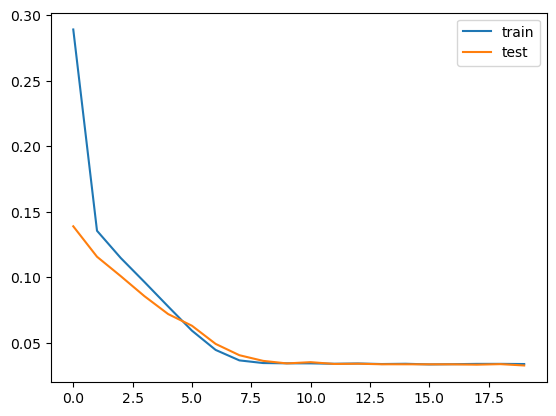

(732, 1, 9) (732,) (184, 1, 9) (184,)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
inv_yhat
(184, 9)


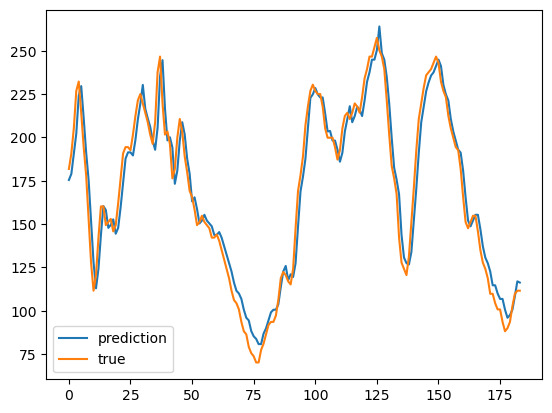

Test RMSE: 10.482
DatetimeIndex(['2021-05-22 11:59:00', '2021-05-22 12:14:00',
               '2021-05-22 12:29:00', '2021-05-22 12:44:00',
               '2021-05-22 12:59:00', '2021-05-22 13:14:00',
               '2021-05-22 13:29:00', '2021-05-22 13:44:00',
               '2021-05-22 13:59:00', '2021-05-22 14:14:00',
               ...
               '2021-06-04 11:29:00', '2021-06-04 11:44:00',
               '2021-06-04 11:59:00', '2021-06-04 12:14:00',
               '2021-06-04 12:29:00', '2021-06-04 12:44:00',
               '2021-06-04 12:59:00', '2021-06-04 13:14:00',
               '2021-06-04 13:29:00', '2021-06-04 13:44:00'],
              dtype='datetime64[ns]', name='Date', length=1256, freq=None)
1255
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(1004, 1, 9) (1004,) (251, 1, 9) (251,)
Epoch 1/20
63/63 - 2s - 27ms/step - loss: 0.2432 - val_loss: 0.1796
Epoch 2/20
63/63 - 0s - 2ms/step - loss: 0.1157 - val_loss: 0.1589
Epoch 3/20
63/63 - 0s - 2ms/step - loss:

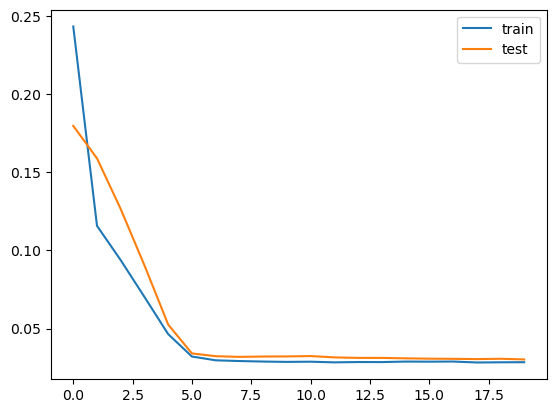

(1004, 1, 9) (1004,) (251, 1, 9) (251,)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
inv_yhat
(251, 9)


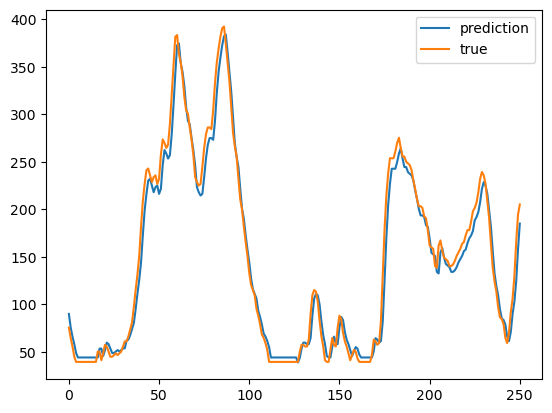

Test RMSE: 14.791
DatetimeIndex(['2021-01-14 18:39:00', '2021-01-14 18:54:00',
               '2021-01-14 19:09:00', '2021-01-14 19:24:00',
               '2021-01-14 19:39:00', '2021-01-14 19:54:00',
               '2021-01-14 20:09:00', '2021-01-14 20:24:00',
               '2021-01-14 20:39:00', '2021-01-14 20:54:00',
               ...
               '2021-01-27 13:09:00', '2021-01-27 13:24:00',
               '2021-01-27 13:39:00', '2021-01-27 13:54:00',
               '2021-01-27 14:09:00', '2021-01-27 14:24:00',
               '2021-01-27 14:39:00', '2021-01-27 14:54:00',
               '2021-01-27 15:09:00', '2021-01-27 15:24:00'],
              dtype='datetime64[ns]', name='Date', length=1236, freq=None)
1235
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(988, 1, 9) (988,) (247, 1, 9) (247,)
Epoch 1/20
62/62 - 2s - 28ms/step - loss: 0.1930 - val_loss: 0.1364
Epoch 2/20
62/62 - 0s - 2ms/step - loss: 0.1196 - val_loss: 0.0902
Epoch 3/20
62/62 - 0s - 2ms/step - loss: 0

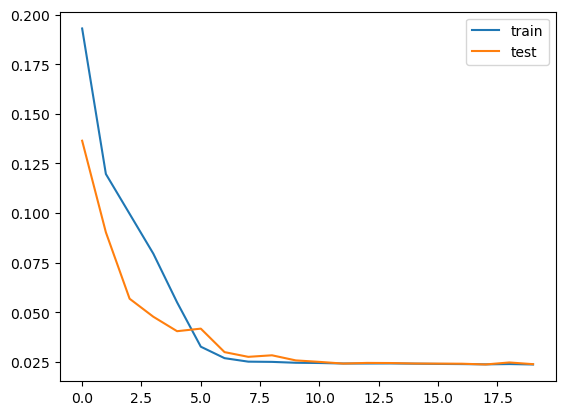

(988, 1, 9) (988,) (247, 1, 9) (247,)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
inv_yhat
(247, 9)


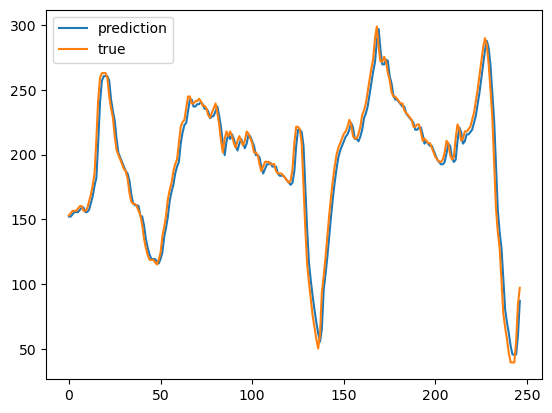

Test RMSE: 9.764
DatetimeIndex(['2021-02-09 13:20:00', '2021-02-09 13:35:00',
               '2021-02-09 13:50:00', '2021-02-09 14:05:00',
               '2021-02-09 14:20:00', '2021-02-09 14:35:00',
               '2021-02-09 14:50:00', '2021-02-09 15:05:00',
               '2021-02-09 15:20:00', '2021-02-09 15:35:00',
               ...
               '2021-02-23 09:35:00', '2021-02-23 09:50:00',
               '2021-02-23 10:05:00', '2021-02-23 10:20:00',
               '2021-02-23 10:35:00', '2021-02-23 10:50:00',
               '2021-02-23 11:05:00', '2021-02-23 11:20:00',
               '2021-02-23 11:35:00', '2021-02-23 11:50:00'],
              dtype='datetime64[ns]', name='Date', length=1339, freq=None)
1338
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(1070, 1, 9) (1070,) (268, 1, 9) (268,)
Epoch 1/20
67/67 - 2s - 28ms/step - loss: 0.2330 - val_loss: 0.1357
Epoch 2/20
67/67 - 0s - 2ms/step - loss: 0.1010 - val_loss: 0.0959
Epoch 3/20
67/67 - 0s - 2ms/step - loss: 

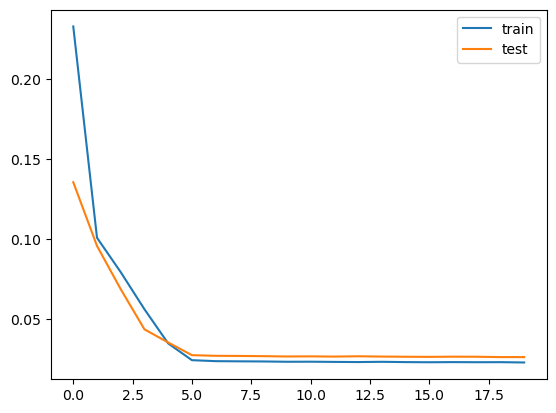

(1070, 1, 9) (1070,) (268, 1, 9) (268,)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
inv_yhat
(268, 9)


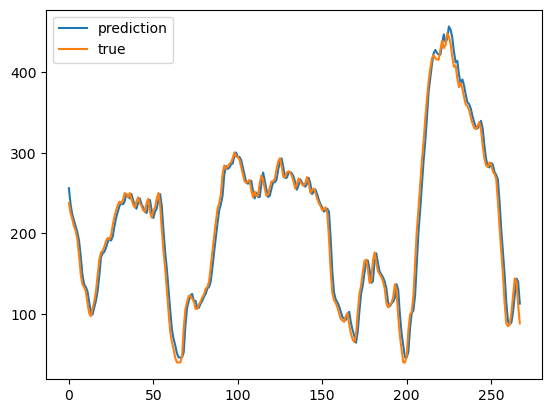

Test RMSE: 13.753
DatetimeIndex(['2021-03-03 15:08:00', '2021-03-03 15:23:00',
               '2021-03-03 15:38:00', '2021-03-03 15:53:00',
               '2021-03-03 16:08:00', '2021-03-03 16:23:00',
               '2021-03-03 16:38:00', '2021-03-03 16:53:00',
               '2021-03-03 17:08:00', '2021-03-03 17:23:00',
               ...
               '2021-03-15 08:23:00', '2021-03-15 08:38:00',
               '2021-03-15 08:53:00', '2021-03-15 09:08:00',
               '2021-03-15 09:23:00', '2021-03-15 09:38:00',
               '2021-03-15 09:53:00', '2021-03-15 10:08:00',
               '2021-03-15 10:23:00', '2021-03-15 10:38:00'],
              dtype='datetime64[ns]', name='Date', length=1135, freq=None)
1134
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(907, 1, 9) (907,) (227, 1, 9) (227,)
Epoch 1/20
57/57 - 2s - 37ms/step - loss: 0.1968 - val_loss: 0.1308
Epoch 2/20
57/57 - 0s - 2ms/step - loss: 0.0854 - val_loss: 0.1054
Epoch 3/20
57/57 - 0s - 2ms/step - loss: 0

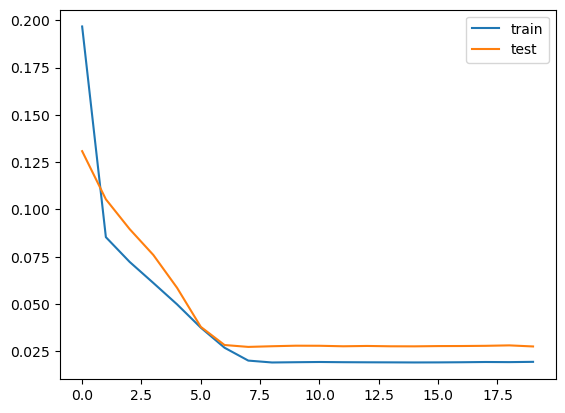

(907, 1, 9) (907,) (227, 1, 9) (227,)
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
inv_yhat
(227, 9)


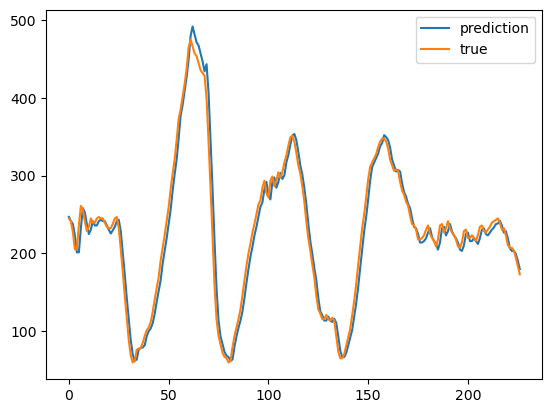

Test RMSE: 15.967
DatetimeIndex(['2021-07-26 09:58:00', '2021-07-26 10:13:00',
               '2021-07-26 10:28:00', '2021-07-26 10:43:00',
               '2021-07-26 10:58:00', '2021-07-26 11:13:00',
               '2021-07-26 11:28:00', '2021-07-26 11:43:00',
               '2021-07-26 11:58:00', '2021-07-26 12:13:00',
               ...
               '2021-08-09 05:43:00', '2021-08-09 05:58:00',
               '2021-08-09 06:13:00', '2021-08-09 06:28:00',
               '2021-08-09 06:43:00', '2021-08-09 06:58:00',
               '2021-08-09 07:13:00', '2021-08-09 07:28:00',
               '2021-08-09 07:43:00', '2021-08-09 07:58:00'],
              dtype='datetime64[ns]', name='Date', length=1337, freq=None)
1336
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(1068, 1, 9) (1068,) (268, 1, 9) (268,)
Epoch 1/20
67/67 - 2s - 28ms/step - loss: 0.1632 - val_loss: 0.1097
Epoch 2/20
67/67 - 0s - 2ms/step - loss: 0.1033 - val_loss: 0.0840
Epoch 3/20
67/67 - 0s - 2ms/step - loss:

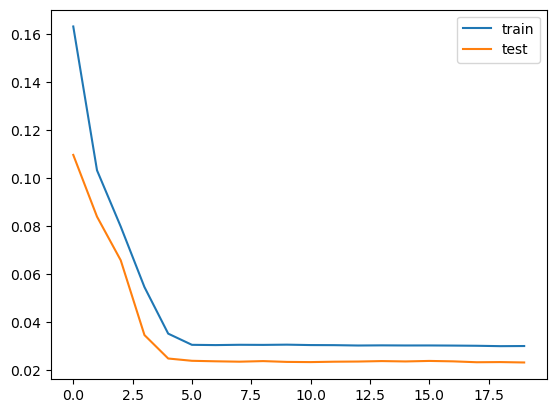

(1068, 1, 9) (1068,) (268, 1, 9) (268,)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
inv_yhat
(268, 9)


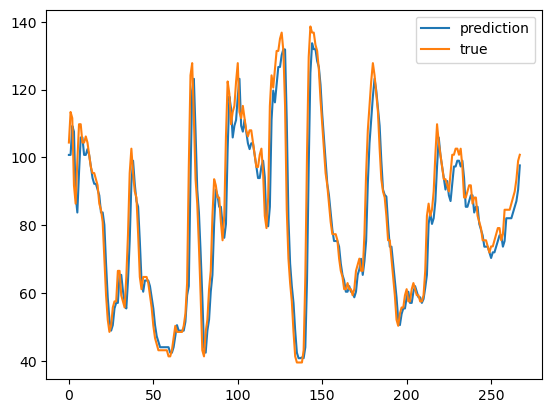

Test RMSE: 7.985
DatetimeIndex(['2021-07-13 16:27:00', '2021-07-13 16:42:00',
               '2021-07-13 16:57:00', '2021-07-13 17:12:00',
               '2021-07-13 17:27:00', '2021-07-13 17:42:00',
               '2021-07-13 17:57:00', '2021-07-13 18:12:00',
               '2021-07-13 18:27:00', '2021-07-13 18:42:00',
               ...
               '2021-07-21 13:27:00', '2021-07-21 13:42:00',
               '2021-07-21 13:57:00', '2021-07-21 14:12:00',
               '2021-07-21 14:27:00', '2021-07-21 14:42:00',
               '2021-07-21 14:57:00', '2021-07-21 15:12:00',
               '2021-07-21 15:27:00', '2021-07-21 15:42:00'],
              dtype='datetime64[ns]', name='Date', length=766, freq=None)
765
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(612, 1, 9) (612,) (153, 1, 9) (153,)
Epoch 1/20
39/39 - 2s - 54ms/step - loss: 0.2594 - val_loss: 0.1148
Epoch 2/20
39/39 - 0s - 2ms/step - loss: 0.1402 - val_loss: 0.1076
Epoch 3/20
39/39 - 0s - 2ms/step - loss: 0.11

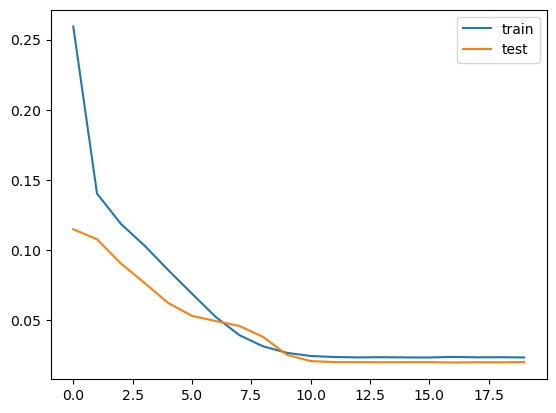

(612, 1, 9) (612,) (153, 1, 9) (153,)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
inv_yhat
(153, 9)


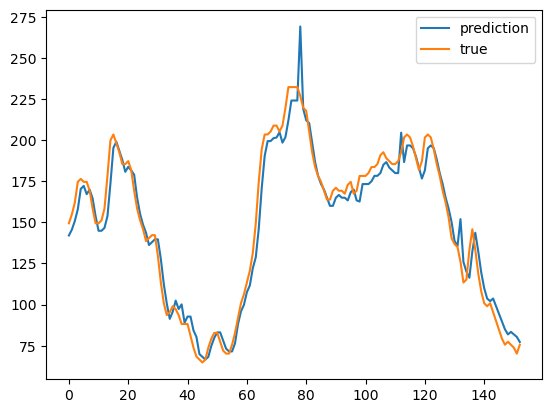

Test RMSE: 9.587
DatetimeIndex(['2021-08-03 12:04:00', '2021-08-03 12:19:00',
               '2021-08-03 12:34:00', '2021-08-03 12:49:00',
               '2021-08-03 13:04:00', '2021-08-03 13:19:00',
               '2021-08-03 13:34:00', '2021-08-03 13:49:00',
               '2021-08-03 14:04:00', '2021-08-03 14:19:00',
               ...
               '2021-08-10 11:49:00', '2021-08-10 12:04:00',
               '2021-08-10 12:19:00', '2021-08-10 12:34:00',
               '2021-08-10 12:49:00', '2021-08-10 13:04:00',
               '2021-08-10 13:19:00', '2021-08-10 13:34:00',
               '2021-08-10 13:49:00', '2021-08-10 14:04:00'],
              dtype='datetime64[ns]', name='Date', length=681, freq=None)
680
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(544, 1, 9) (544,) (136, 1, 9) (136,)
Epoch 1/20
34/34 - 2s - 47ms/step - loss: 0.3262 - val_loss: 0.1100
Epoch 2/20
34/34 - 0s - 3ms/step - loss: 0.1341 - val_loss: 0.2021
Epoch 3/20
34/34 - 0s - 2ms/step - loss: 0.10

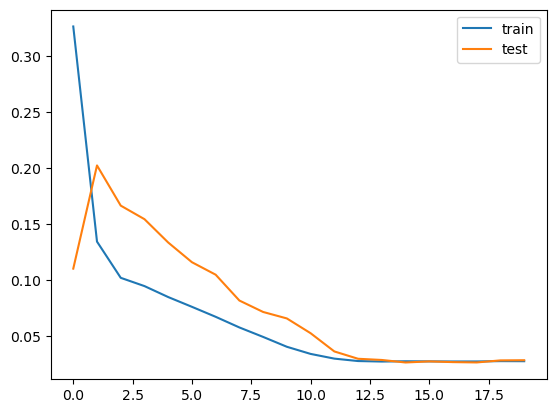

(544, 1, 9) (544,) (136, 1, 9) (136,)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
inv_yhat
(136, 9)


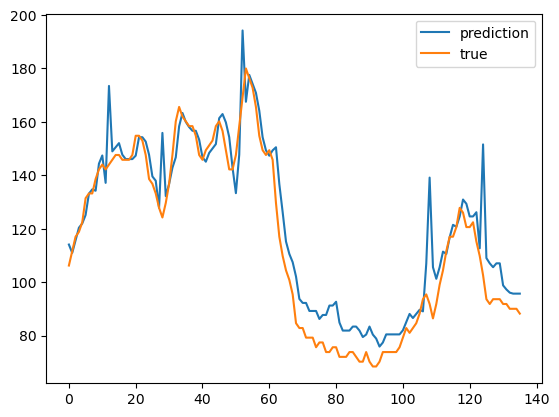

Test RMSE: 11.000
DatetimeIndex(['2021-09-14 17:30:00', '2021-09-14 17:45:00',
               '2021-09-14 18:00:00', '2021-09-14 18:15:00',
               '2021-09-14 18:30:00', '2021-09-14 18:45:00',
               '2021-09-14 19:00:00', '2021-09-14 19:15:00',
               '2021-09-14 19:30:00', '2021-09-14 19:45:00',
               ...
               '2021-09-24 04:30:00', '2021-09-24 04:45:00',
               '2021-09-24 05:00:00', '2021-09-24 05:15:00',
               '2021-09-24 05:30:00', '2021-09-24 05:45:00',
               '2021-09-24 06:00:00', '2021-09-24 06:15:00',
               '2021-09-24 06:30:00', '2021-09-24 06:45:00'],
              dtype='datetime64[ns]', name='Date', length=918, freq=None)
917
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(733, 1, 9) (733,) (184, 1, 9) (184,)
Epoch 1/20
46/46 - 2s - 39ms/step - loss: 0.3083 - val_loss: 0.1163
Epoch 2/20
46/46 - 0s - 2ms/step - loss: 0.1316 - val_loss: 0.1360
Epoch 3/20
46/46 - 0s - 2ms/step - loss: 0.1

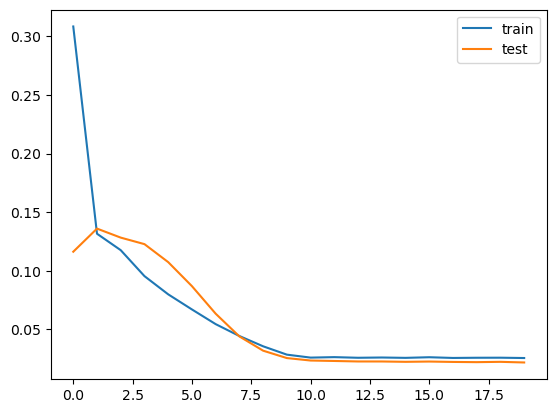

(733, 1, 9) (733,) (184, 1, 9) (184,)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
inv_yhat
(184, 9)


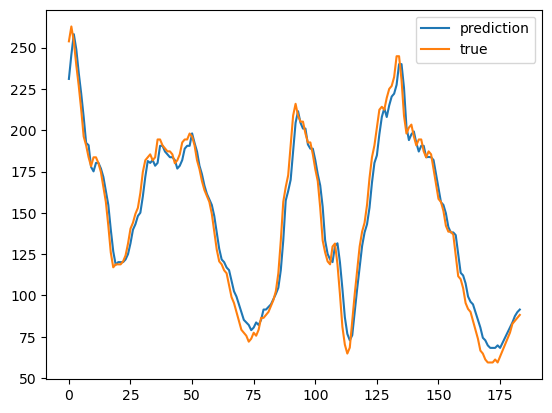

Test RMSE: 8.834
DatetimeIndex(['2021-06-22 17:23:00', '2021-06-22 17:38:00',
               '2021-06-22 17:53:00', '2021-06-22 18:08:00',
               '2021-06-22 18:23:00', '2021-06-22 18:38:00',
               '2021-06-22 18:53:00', '2021-06-22 19:08:00',
               '2021-06-22 19:23:00', '2021-06-22 19:38:00',
               ...
               '2021-06-28 04:53:00', '2021-06-28 05:08:00',
               '2021-06-28 05:23:00', '2021-06-28 05:38:00',
               '2021-06-28 05:53:00', '2021-06-28 06:08:00',
               '2021-06-28 06:23:00', '2021-06-28 06:38:00',
               '2021-06-28 06:53:00', '2021-06-28 07:08:00'],
              dtype='datetime64[ns]', name='Date', length=536, freq=None)
535
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(428, 1, 9) (428,) (107, 1, 9) (107,)
Epoch 1/20
27/27 - 2s - 66ms/step - loss: 0.2413 - val_loss: 0.1512
Epoch 2/20
27/27 - 0s - 2ms/step - loss: 0.1553 - val_loss: 0.0804
Epoch 3/20
27/27 - 0s - 3ms/step - loss: 0.12

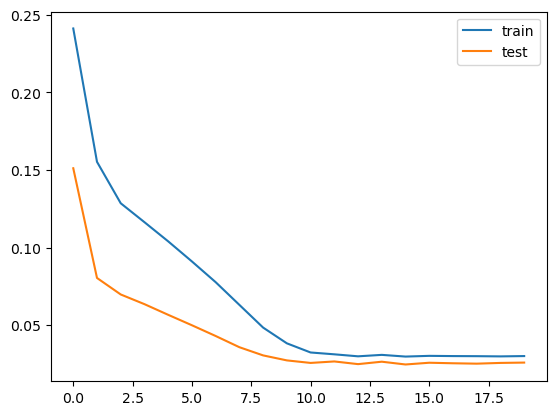

(428, 1, 9) (428,) (107, 1, 9) (107,)
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
inv_yhat
(107, 9)


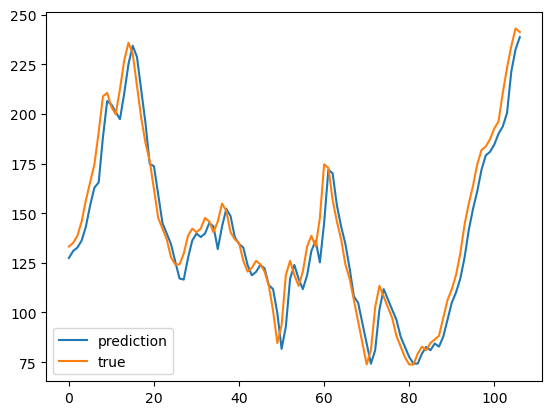

Test RMSE: 10.330
DatetimeIndex(['2021-09-23 01:08:00', '2021-09-23 01:23:00',
               '2021-09-23 01:38:00', '2021-09-23 01:53:00',
               '2021-09-23 02:08:00', '2021-09-23 02:23:00',
               '2021-09-23 02:38:00', '2021-09-23 02:53:00',
               '2021-09-23 03:08:00', '2021-09-23 03:23:00',
               ...
               '2021-10-06 21:23:00', '2021-10-06 21:38:00',
               '2021-10-06 21:53:00', '2021-10-06 22:08:00',
               '2021-10-06 22:23:00', '2021-10-06 22:38:00',
               '2021-10-06 22:53:00', '2021-10-06 23:08:00',
               '2021-10-06 23:23:00', '2021-10-06 23:38:00'],
              dtype='datetime64[ns]', name='Date', length=1339, freq=None)
1338
train_x.shape, train_y.shape, test_x.shape, test_y.shape
(1070, 1, 9) (1070,) (268, 1, 9) (268,)
Epoch 1/20
67/67 - 2s - 32ms/step - loss: 0.2042 - val_loss: 0.1156
Epoch 2/20
67/67 - 0s - 2ms/step - loss: 0.1021 - val_loss: 0.0924
Epoch 3/20
67/67 - 0s - 1ms/step - loss:

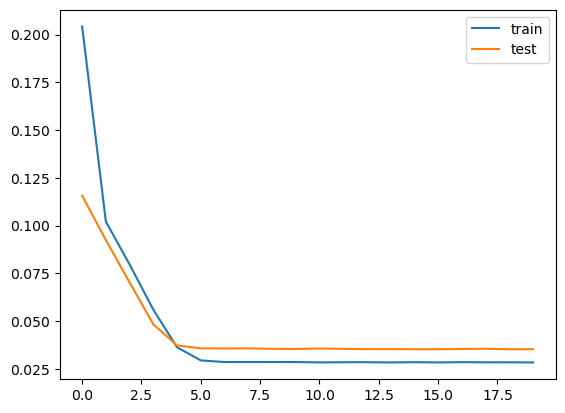

(1070, 1, 9) (1070,) (268, 1, 9) (268,)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
inv_yhat
(268, 9)


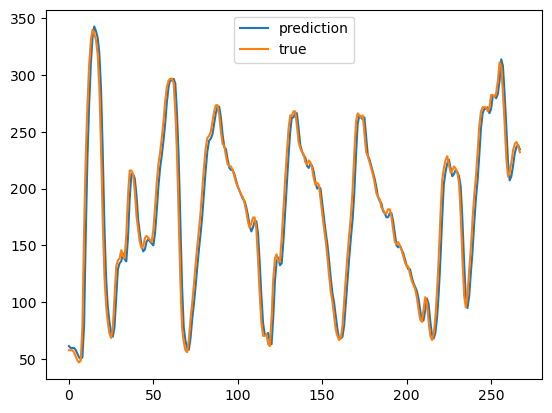

Test RMSE: 17.486


In [44]:
import os
def lstm_file(data_type,date_no):
    df=get_dataframe(data_type,date_no)
    rf,scaler=fine_preprocess(data_type,date_no)
    train_X,train_y,test_X,test_y=split_data(rf)
    model=train(data_type,date_no,train_X,train_y,test_X,test_y)
    inv_y, inv_yhat=predict(model,scaler,train_X,train_y,test_X,test_y)
    cal_rmse(inv_y, inv_yhat)
for root, dirs, files in os.walk('Shanghai_T1DM'):
        for file in files:
            lstm_file('Shanghai_T1DM',file)
for root, dirs, files in os.walk('Shanghai_T2DM'):
        for file in files:
            lstm_file('Shanghai_T2DM',file)